<a href="https://colab.research.google.com/github/pratulsrinivasan/Light_Field_Blind_Motion_Deblurring/blob/master/2D_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D CT reconstruction with sparse bvals
**Most of what is here currently will go / be modified**

The strategy to determine the bval distribution will mirror the large scale 1D method.

Included: \\

ToDo: \\

*   Teaser comparision, image with and without encodings
*   Table comparing different encodings over a dataset of images
    *   Maybe use multiple datasets with different statistics



In [2]:
!pip install -q livelossplot
!pip install -q tensorflow-datasets
!pip install phantominator
import os

     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [0]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
import jax.numpy as np
from jax.scipy import ndimage
from jax.experimental import optimizers, stax
import random as py_random

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os

import imageio
import string
# from PIL import Image, ImageDraw, ImageFont

import cv2
import scipy.ndimage
from scipy.special import binom

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm as tqdm
import numpy as onp

from phantominator import shepp_logan, ct_shepp_logan, ct_modified_shepp_logan_params_2d

## Random seed
rand_key = random.PRNGKey(10)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


[[ 0.9663184   0.6259183   0.9874412  -0.05023594  0.08294013  0.0168003 ]
 [-0.8433307   0.7213384   0.8326808   0.00152271 -0.08326855 -0.0035296 ]
 [-0.1821      0.11739829  0.28683433  0.2405069   0.02897128 -0.31050888]
 [-0.2003445   0.11660337  0.48180708 -0.20200208 -0.0135451   0.30801353]
 [ 0.11969424  0.16092572  0.26941416 -0.02636824  0.3687426   0.08564779]
 [ 0.19682652  0.05078758  0.07976241  0.00605652  0.16955271 -0.06372187]
 [ 0.20302518  0.10043901  0.13163853 -0.04216076 -0.03553645 -0.10453373]
 [ 0.22229743  0.09447739  0.08333374 -0.09271213 -0.51013947  0.0971558 ]
 [ 0.08535942 -0.08426517  0.05520637 -0.04481722 -0.5824372   0.07112468]
 [ 0.13479984 -0.0131696   0.0509947   0.07576514 -0.5712022  -0.01338237]]


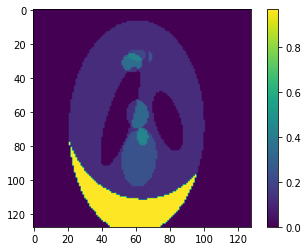

In [181]:
ct_params = np.array(ct_modified_shepp_logan_params_2d())
rand_key, subkey = random.split(rand_key)
ct_params += random.normal(subkey, shape=ct_params.shape)/20.0
print(ct_params)
ph = np.clip(ct_shepp_logan((128,128), E=ct_params), 0.0, 1.0)
plt.figure()
plt.imshow(ph)
plt.colorbar()

In [0]:
#@markdown #Global Defaults

#@markdown resolution
RES = 256 #@param

In [0]:
#@title NP Area Resize Code

# from https://gist.github.com/shoyer/c0f1ddf409667650a076c058f9a17276

def _reflect_breaks(size: int) -> np.ndarray:
  """Calculate cell boundaries with reflecting boundary conditions."""
  result = np.concatenate([[0], 0.5 + np.arange(size - 1), [size - 1]])
  assert len(result) == size + 1
  return result
  
def _interval_overlap(first_breaks: np.ndarray,
                      second_breaks: np.ndarray) -> np.ndarray:
  """Return the overlap distance between all pairs of intervals.

  Args:
    first_breaks: breaks between entries in the first set of intervals, with
      shape (N+1,). Must be a non-decreasing sequence.
    second_breaks: breaks between entries in the second set of intervals, with
      shape (M+1,). Must be a non-decreasing sequence.

  Returns:
    Array with shape (N, M) giving the size of the overlapping region between
    each pair of intervals.
  """
  first_upper = first_breaks[1:]
  second_upper = second_breaks[1:]
  upper = np.minimum(first_upper[:, np.newaxis], second_upper[np.newaxis, :])

  first_lower = first_breaks[:-1]
  second_lower = second_breaks[:-1]
  lower = np.maximum(first_lower[:, np.newaxis], second_lower[np.newaxis, :])

  return np.maximum(upper - lower, 0)

def _resize_weights(
    old_size: int, new_size: int, reflect: bool = False) -> np.ndarray:
  """Create a weight matrix for resizing with the local mean along an axis.

  Args:
    old_size: old size.
    new_size: new size.
    reflect: whether or not there are reflecting boundary conditions.

  Returns:
    NumPy array with shape (new_size, old_size). Rows sum to 1.
  """
  if not reflect:
    old_breaks = np.linspace(0, old_size, num=old_size + 1)
    new_breaks = np.linspace(0, old_size, num=new_size + 1)
  else:
    old_breaks = _reflect_breaks(old_size)
    new_breaks = (old_size - 1) / (new_size - 1) * _reflect_breaks(new_size)

  weights = _interval_overlap(new_breaks, old_breaks)
  weights /= np.sum(weights, axis=1, keepdims=True)
  assert weights.shape == (new_size, old_size)
  return weights

def resize(array: np.ndarray,
           shape: [int, ...],
           reflect_axes: [int] = ()) -> np.ndarray:
  """Resize an array with the local mean / bilinear scaling.

  Works for both upsampling and downsampling in a fashion equivalent to
  block_mean and zoom, but allows for resizing by non-integer multiples. Prefer
  block_mean and zoom when possible, as this implementation is probably slower.

  Args:
    array: array to resize.
    shape: shape of the resized array.
    reflect_axes: iterable of axis numbers with reflecting boundary conditions,
      mirrored over the center of the first and last cell.

  Returns:
    Array resized to shape.

  Raises:
    ValueError: if any values in reflect_axes fall outside the interval
      [-array.ndim, array.ndim).
  """
  reflect_axes_set = set()
  for axis in reflect_axes:
    if not -array.ndim <= axis < array.ndim:
      raise ValueError('invalid axis: {}'.format(axis))
    reflect_axes_set.add(axis % array.ndim)

  output = array
  for axis, (old_size, new_size) in enumerate(zip(array.shape, shape)):
    reflect = axis in reflect_axes_set
    weights = _resize_weights(old_size, new_size, reflect=reflect)
    product = np.tensordot(output, weights, [[axis], [-1]])
    output = np.moveaxis(product, -1, axis)
  return output

In [0]:
#@title Shepp Data Gen

def get_shepp_dataset(rand_key, num_grid_search_samples, test_samples):
    total_samples = num_grid_search_samples + test_samples

    ct_params = np.array(ct_modified_shepp_logan_params_2d())

    shepps = []
    for i in range(total_samples):
        rand_key, subkey = random.split(rand_key)
        i_ct_params = ct_params + random.normal(subkey, shape=ct_params.shape)/20.0
        shepps.append(np.clip(ct_shepp_logan((RES,RES), E=i_ct_params), 0.0, 1.0))

    samples = np.stack(shepps, axis=0)

    out = {
        "data_grid_search":np.array(samples[:num_grid_search_samples,:,:]),
        "data_test":np.array(samples[num_grid_search_samples:,:,:]),
    }
    return out

Loading Shepp Dataset
Shepp Dataset Loaded
Dataset shepp


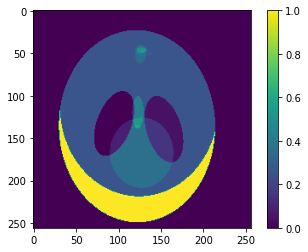

In [233]:
#@title Load Datasets

visualize = True #@param {type:"boolean"}
num_grid_search_samples = 10 #@param
num_test_samples =  10#@param

#@markdown Shepp Dataset
load_shepp = True #@param {type:"boolean"}

datasets = {}
if load_shepp:
    print('Loading Shepp Dataset')
    datasets['shepp'] = get_shepp_dataset(rand_key, num_grid_search_samples, num_test_samples)
    print('Shepp Dataset Loaded')

x1 = np.linspace(0, 1, RES+1)[:-1] # use full image resolution 
x_train = np.stack(np.meshgrid(x1,x1), axis=-1)
x_test = x_train

def plot_dataset(dataset):
    plt.imshow(dataset['data_test'][0,:,:])
    plt.colorbar()
    plt.show()

if visualize:
    for dataset in datasets:
        print(f'Dataset {dataset}')
        plot_dataset(datasets[dataset])

# Network setup

In [0]:
#@title Define ReLU Network

network_depth = 8 #@param
network_width = 256 #@param

def make_network(num_layers, num_channels):
  layers = []
  for i in range(num_layers-1):
      layers.append(stax.Dense(num_channels))
      layers.append(stax.Relu)
  layers.append(stax.Dense(1))
  layers.append(stax.Sigmoid)
  return stax.serial(*layers)

init_fn, apply_fn = make_network(network_depth, network_width)

## Setup 2D encoder

Our 2D input embedding is of the form: \
> $\gamma(\mathbf v) = (a_0 \sin(\pi b_0^\top \mathbf v), a_0 \cos(\pi b_0^\top \mathbf v),a_1 \sin(\pi b_1^\top \mathbf v), a_1 \cos(\pi b_1^\top \mathbf v),...)$

This creates a kernel of the form: \
> $k_\gamma(\mathbf v_1, \mathbf v_2) = \sum_{i=1}^m a_i^2 \cos(\pi b_i^\top (\mathbf v_1 - \mathbf v_2))$

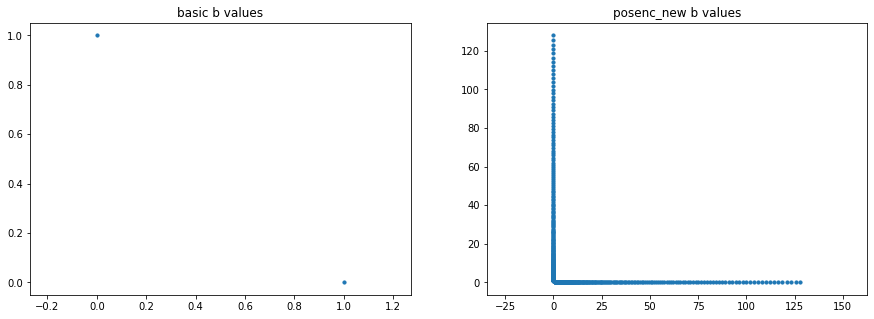

In [260]:
#@title Generate Fixed Embeddings

embedding_size = 256 #@param

include_basic = True #@param {type:"boolean"}
include_posenc = False #@param {type:"boolean"}
#@markdown same as posenc, but with more samples
include_new_posenc = True #@param {type:"boolean"}
visualize = []

enc_dict = {}

input_encoder = lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x) @ b.T), 
                                                a * np.cos((2.*np.pi*x) @ b.T)], axis=-1) / np.linalg.norm(a) * np.sqrt(a.shape[0])

# Basic
if include_basic:
    bvals = np.eye(2)
    avals = np.ones((bvals.shape[0])) 
    enc_dict['basic'] = (avals, bvals)
    visualize.append('basic')

# PosEnc
if include_posenc:
    mres = np.log2(RES//2)
    bvals = 2.**np.arange(mres)
    bvals = np.stack([bvals, np.zeros_like(bvals)], -1)
    bvals = np.concatenate([bvals, np.roll(bvals, 1, axis=-1)], 0) + 0
    avals = np.ones((bvals.shape[0])) 
    enc_dict['posenc'] = (avals, bvals)
    visualize.append('posenc')

# New PosEnc
if include_new_posenc:
    mres = np.log2(RES//2)
    bvals = 2.**np.linspace(0,mres,embedding_size)
    bvals = np.stack([bvals, np.zeros_like(bvals)], -1)
    bvals = np.concatenate([bvals, np.roll(bvals, 1, axis=-1)], 0) + 0
    avals = np.ones((bvals.shape[0])) 
    enc_dict['posenc_new'] = (avals, bvals)
    visualize.append('posenc_new')

def visualize_encoders(enc_dict, keys=None):
    if keys is None:
        keys = enc_dict.keys()

    P = len(keys)
    plt.figure(figsize=(15,5))
    slices = {}
    for i, enc in enumerate(keys):
        plt.subplot(1,P,i+1)
        avals, bvals = enc_dict[enc]
        plt.scatter(bvals[:,0], bvals[:,1], marker='o', s=10, label=enc)
        plt.title(f'{enc} b values')
        plt.axis('equal')
    plt.show()

if len(visualize) != 0:
    visualize_encoders(enc_dict, visualize)

# CT Projection

In [0]:
@jit
def ct_project(img, theta):
    y, x = np.meshgrid(np.arange(int(img.shape[0]), dtype=np.float32)/int(img.shape[0]) - 0.5, np.arange(int(img.shape[1]), dtype=np.float32)/int(img.shape[1]) - 0.5, indexing='ij')
    x_rot = x*np.cos(theta) - y*np.sin(theta)
    y_rot = x*np.sin(theta) + y*np.cos(theta)
    x_rot = (x_rot + 0.5)*img.shape[1]
    y_rot = (y_rot + 0.5)*img.shape[0]
    sample_coords = np.stack([y_rot, x_rot], axis=0)
    resampled = ndimage.map_coordinates(img, sample_coords, 0).reshape(img.shape)
    return resampled.mean(axis=0)[:,None,...]

ct_project_batch = vmap(ct_project, (None, 0), 0)

# Train Model

In [0]:
run_model = jit(lambda params, x: np.reshape(apply_fn(params, np.reshape(x, (-1, x.shape[-1]))), (x.shape[0], x.shape[1])))
compute_projs = jit(lambda params, x, thetas: ct_project_batch(run_model(params, x), thetas))
model_loss_proj = jit(lambda params, x, y, thetas: .5 * np.mean((compute_projs(params, x, thetas) - y) ** 2))
model_loss = jit(lambda params, x, y, thetas, image: .5 * np.abs(np.mean((np.clip(run_model(params, x), 0.0, 1.0) - image) ** 2)))
model_psnr = jit(lambda params, x, y, thetas, image: -10 * np.log10(2.*model_loss(params, x, y, thetas, image)))
model_grad_loss = jit(lambda params, x, y, thetas, image: jax.grad(model_loss_proj)(params, x, y, thetas))


GROUPS_MODEL = {'Test PSNR':[], 'Train PSNR':[]}
def train_model(lr, iters, train_data, test_data, name='', plot_groups=None):
    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, train_data[0].shape[-1]))
    opt_state = opt_init(params)

    train_psnrs = []
    test_psnrs = []
    xs = []
    if plot_groups is not None:
        plot_groups['Test PSNR'].append(f'{name}_test')
        plot_groups['Train PSNR'].append(f'{name}_train')
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)
        if i % 25 == 0:
            train_psnr = model_psnr(get_params(opt_state), *train_data)
            test_psnr = model_psnr(get_params(opt_state), *test_data)
            train_psnrs.append(train_psnr)
            test_psnrs.append(test_psnr)
            xs.append(i)
            if plot_groups is not None:
                plotlosses_model.update({f'{name}_train':train_psnr, f'{name}_test':test_psnr}, current_step=i)
        if i % 100 == 0 and i != 0 and plot_groups is not None:
            plotlosses_model.send()
    if plot_groups is not None:
        plotlosses_model.send()
    results = {
        'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'xs': xs
    }
    return results

In [0]:
#@title CT projection parameters

num_thetas = 20#@param

searching over, [1. 2. 3. 4. 5.]


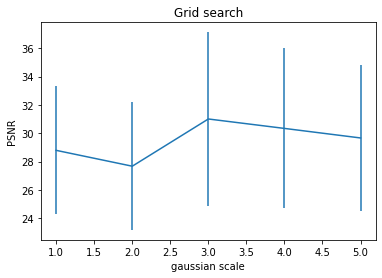

Adding gaussian scale 3.0 to encoding methods


In [264]:
#@title Grid Search bval distributions
#@markdown The models are trained on a different set of data. The top distribution is added to the list. Currently implements scaled gaussians.

lr =  8e-4#@param
training_steps =  1000#@param
target_distribution = "shepp" #@param ["shepp"]
num_images =  3#@param
min_scale =  1#@param
max_scale =  5#@param
num_scales =  5#@param

bvals = random.normal(rand_key, (embedding_size, 2))
avals = np.ones((bvals.shape[0])) 
scales = np.linspace(min_scale, max_scale, num_scales)
print(f'searching over, {scales}')

if num_images == 1:
    plt_groups = {'Test PSNR':[], 'Train PSNR':[]}
    plotlosses_model = PlotLosses(groups=plt_groups)
else:
    plt_groups = None
result_psnrs = []
for scale in tqdm(scales, desc=f'Scale {scale}', leave=False):
    scale_results = []
    for i in tqdm(range(num_images), desc=f'Image {i}', leave=False):
        image = datasets[target_distribution]['data_grid_search'][i,:,:]
        thetas = np.linspace(0.0, 2.0*np.pi, num_thetas)
        # compute projections
        y_train = ct_project_batch(image, thetas)
        y_test = y_train # don't need extra projs for CT (performance is on recon.)
        train_data = (input_encoder(x_train, avals, bvals*scale), y_train, thetas, image)
        test_data = (input_encoder(x_test, avals, bvals*scale), y_test, thetas, image)
        scale_results.append(train_model(lr, training_steps, train_data, test_data, 
                                         name=scale, plot_groups=plt_groups)['test_psnrs'][-1])
    result_psnrs.append(scale_results)

result_psnrs = np.array(result_psnrs)
plt.errorbar(scales, np.mean(result_psnrs, axis=-1), yerr=np.std(result_psnrs, axis=-1))
plt.title('Grid search')
plt.xlabel('gaussian scale')
plt.ylabel('PSNR')
plt.show()

best_scale = scales[np.argmax(np.mean(result_psnrs, axis=-1))]
print(f'Adding gaussian scale {best_scale} to encoding methods')
enc_dict[f'gaussian_{"%.2f" % best_scale}'] = (avals, bvals*scale)

In [265]:
#@title Train Models

lr =  8e-4#@param
training_steps =  1000#@param

target_distribution = "shepp" #@param ["shepp"]

include_no_encoding = True #@param {type:"boolean"}

#@markdown If ensemble_size > 1, live plots are not rendered.
ensemble_size =  3#@param


if ensemble_size == 1:
    plt_groups = {'Test PSNR':[], 'Train PSNR':[]}
    plotlosses_model = PlotLosses(groups=plt_groups)
else:
    plt_groups = None

outputs = {}
if include_no_encoding:
    outputs['no_encoding'] = []
    for i in tqdm(range(ensemble_size), desc='no encoding', leave=False):
      image = datasets[target_distribution]['data_test'][i,:,:]
      thetas = np.linspace(0.0, 2.0*np.pi, num_thetas)
      # compute projections
      y_train = ct_project_batch(image, thetas)
      y_test = y_train # don't need extra projs for CT (performance is on recon.)
      outputs['no_encoding'].append(train_model(lr, training_steps, 
                                                (x_train, y_train, thetas, image), 
                                                (x_test, y_test, thetas, image), 
                                                name='no_encoding', plot_groups=plt_groups))

for k in tqdm(enc_dict, leave=False):
    outputs[k] = []
    for i in tqdm(range(ensemble_size), desc=k, leave=False):
      image = datasets[target_distribution]['data_test'][i,:,:]
      thetas = np.linspace(0.0, 2.0*np.pi, num_thetas)
      # compute projections
      y_train = ct_project_batch(image, thetas)
      y_test = y_train # don't need extra projs for CT (performance is on recon.)
      train_data = (input_encoder(x_train, *enc_dict[k]), y_train, thetas, image)
      test_data = (input_encoder(x_test, *enc_dict[k]), y_test, thetas, image)
      outputs[k].append(train_model(lr, training_steps, train_data, test_data, name=k, plot_groups=plt_groups))

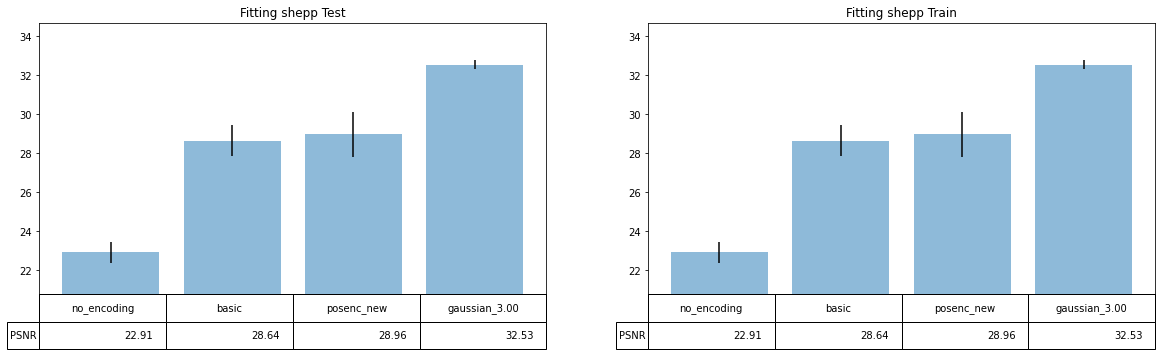

----------------------------------------
                  Test
----------------------------------------


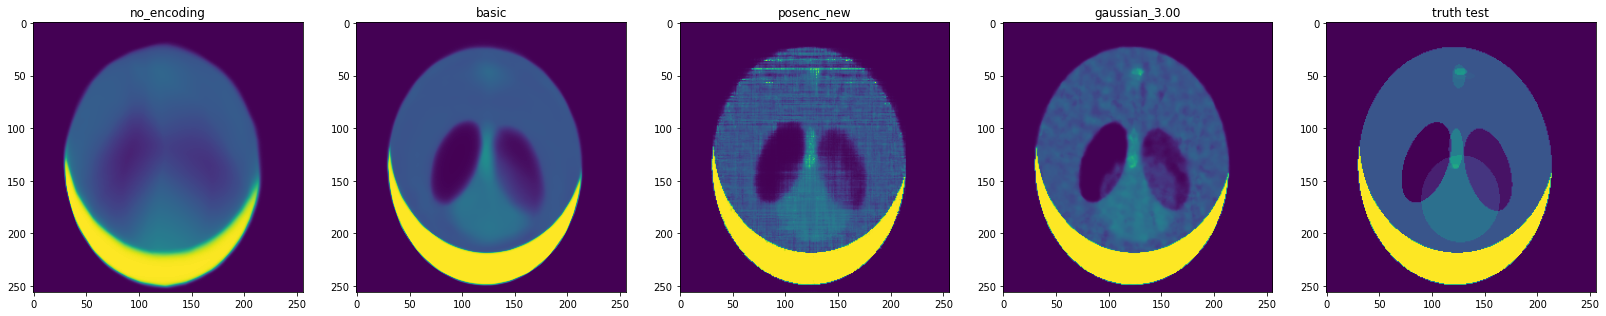

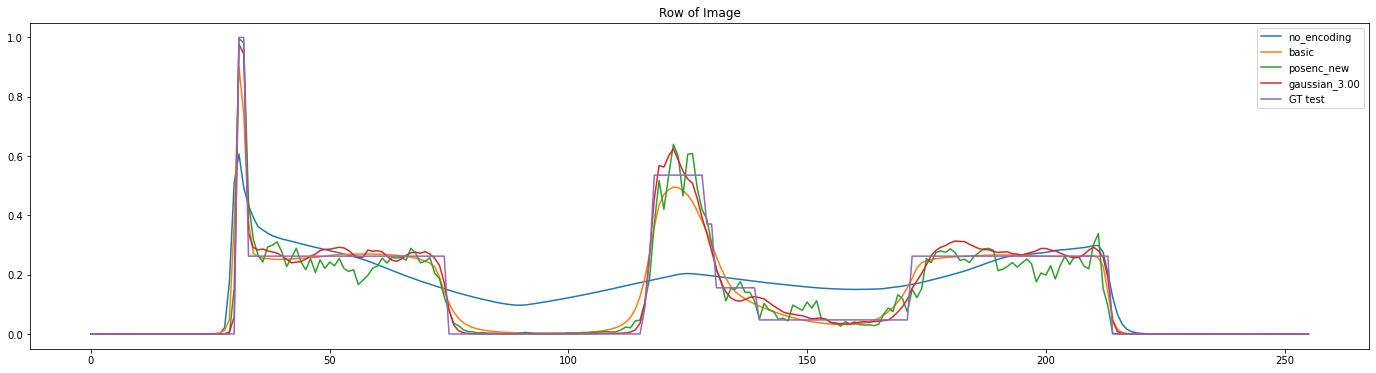

In [266]:
#@title Plot Results

bar_graph = True #@param {type:"boolean"}
image_reconstructions = True #@param {type:"boolean"}
image_slice = True #@param {type:"boolean"}
test_img_id =  0#@param

names = list(outputs.keys())

image_test = datasets[target_distribution]['data_test'][test_img_id,:,:]

xvals = np.arange(len(names))
test_values = np.array([[outputs[n][i]['test_psnrs'][-1] for i in range(len(outputs[n]))] for n in names])
test_values_mean = np.mean(test_values, axis=-1)
test_values_std = np.std(test_values, axis=-1)
train_values = np.array([[outputs[n][i]['train_psnrs'][-1] for i in range(len(outputs[n]))] for n in names])
train_values_mean = np.mean(train_values, axis=-1)
train_values_std = np.std(train_values, axis=-1)
inds = np.argsort(test_values_mean)
names_sort = [names[i] for i in inds]

if bar_graph:
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.bar(xvals+2, test_values_mean[inds], color=colors[0], alpha=.5, yerr=test_values_std)
    plt.xticks([])
    plt.ylim(test_values_mean.min()-test_values_std.max()-1, test_values_mean.max()+test_values_std.max()+1)
    plt.title(f'Fitting {target_distribution} Test')
    prnt_vals = ['%.2f' % x for x in test_values_mean[inds].tolist()]
    plt.table(cellText=[prnt_vals], 
              rowLabels=['PSNR'], 
              colLabels=names_sort, 
              loc='bottom', 
              bbox=[0, -.2, 1, 0.2])

    plt.subplot(1,2,2)
    plt.bar(xvals, train_values_mean[inds], color=colors[0], alpha=.5, yerr=train_values_std)
    # plt.xticks(xvals, names_sort, rotation=60)
    plt.xticks([])
    plt.ylim(train_values_mean.min()-train_values_std.max()-1, train_values_mean.max()+train_values_std.max()+1)
    plt.title(f'Fitting {target_distribution} Train')
    plt.table(cellText=[['%.2f' % x for x in train_values_mean[inds].tolist()]],
        rowLabels=['PSNR'],
        colLabels=names_sort,
        loc='bottom',
        bbox=[0, -.2, 1, 0.2])
    
    plt.show()

if image_reconstructions:
    print('----------------------------------------')
    print('                  Test')
    print('----------------------------------------')
    plt.figure(figsize=(28,6))
    for i, p in enumerate(names_sort):
        if p in enc_dict:
            pred = apply_fn(outputs[p][test_img_id]['state'], input_encoder(x_test, *enc_dict[p])).reshape(RES,RES)
        else:
            pred = apply_fn(outputs[p][test_img_id]['state'], x_test).reshape(RES,RES)
        plt.subplot(1,len(names)+1,i+1)
        plt.imshow(pred)
        plt.title(p)

    plt.subplot(1,len(names)+1,len(names)+1)
    plt.imshow(image_test)
    plt.title('truth test')
    plt.show()

if image_slice:
    plt.figure(figsize=(24,6))
    for i, p in enumerate(names_sort):
        if p in enc_dict:
            pred = apply_fn(outputs[p][0]['state'], input_encoder(x_test, *enc_dict[p]))
        else:
            pred = apply_fn(outputs[p][0]['state'], x_test)
        plt.plot(pred[pred.shape[0]//2], label=p)
    plt.plot(image_test[image_test.shape[0]//2], label='GT test')
    plt.legend()
    plt.title('Row of Image')
    plt.show()